<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.


In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
!pip install -q catalyst
from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 8.2 MB/s eta 0:00:00


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

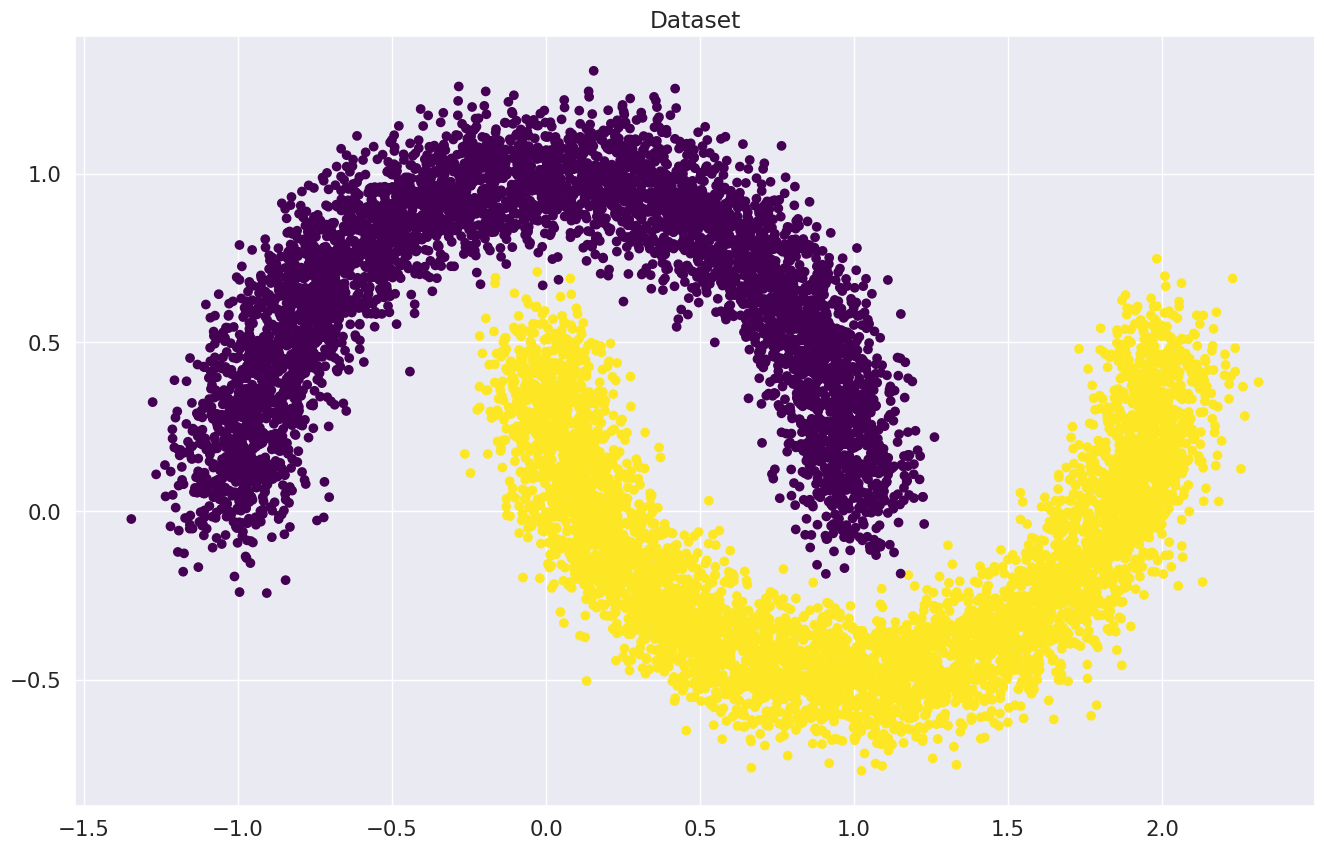

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
# YOUR CODE GOES HERE
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool=True):
        super().__init__()
        # YOUR CODE GOES HERE
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True))

    def forward(self, x):
        # YOUR CODE GOES HERE
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
# YOUR CODE GOES HERE
!pip install torchinfo
from torchinfo import summary
summary(linear_regression, (2,), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # YOUR CODE GOES HERE
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        y_batch = y_batch.view(-1, 1)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.3125
Iteration: 100
Batch accuracy: 64.9375
Iteration: 200
Batch accuracy: 64.390625
Iteration: 300
Batch accuracy: 65.09375
Iteration: 400
Batch accuracy: 64.046875
Iteration: 500
Batch accuracy: 64.0625
Iteration: 600
Batch accuracy: 65.5
Iteration: 700
Batch accuracy: 63.875

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 755

### Визуализируем результаты

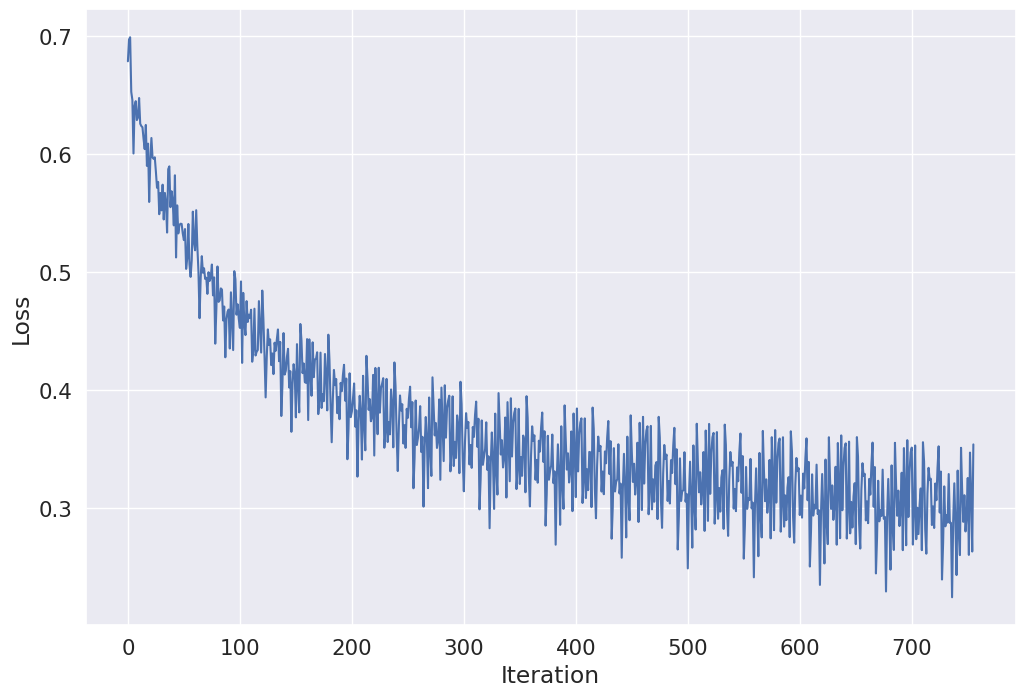

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

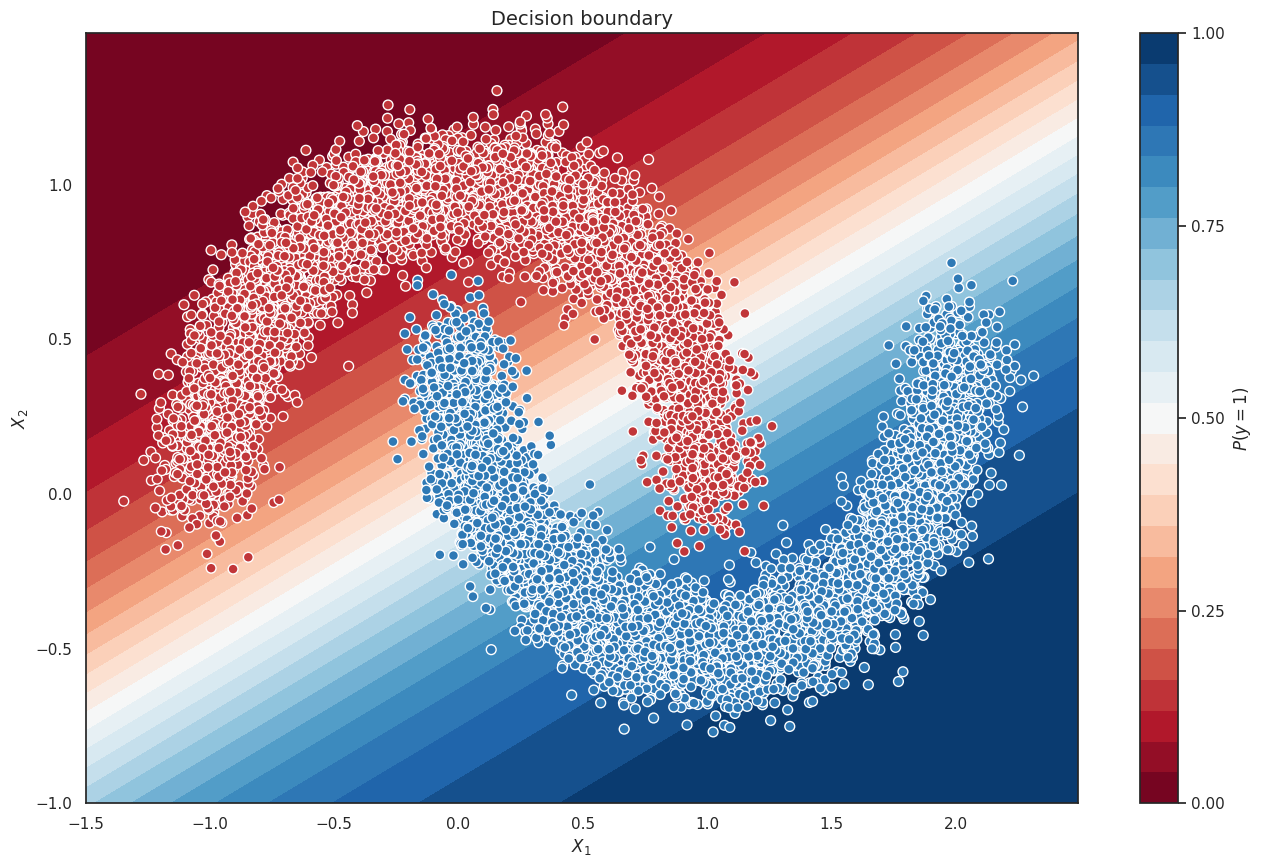

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([], dtype='int64')
    for x_batch, _ in dataloader:
        # YOUR CODE GOES HERE
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
# YOUR CODE GOES HERE
y_predict = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_predict)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.862

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
import torchvision
import PIL
from torchvision import datasets, transforms, models

data_tfs = transforms.Compose([
    #transforms.Resize(256, interpolation=PIL.Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)
# YOUR CODE GOES HERE
train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 112203031.37it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62216586.45it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30590190.27it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12950733.36it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



torch.Size([28, 28])


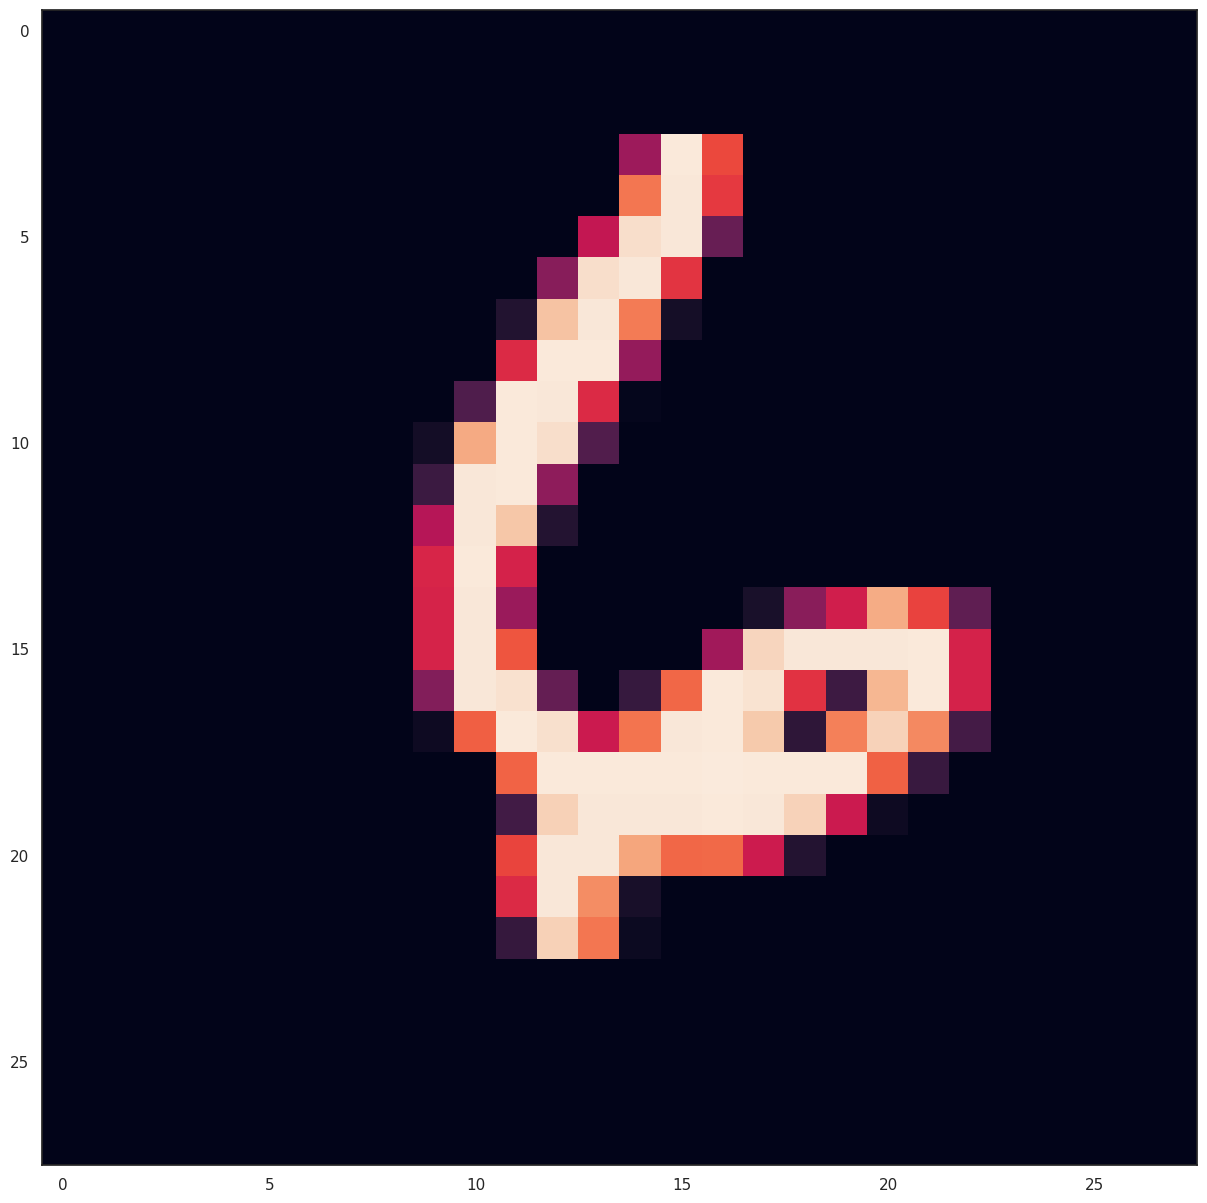

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
img = np.array(train_dataset[59000][0][0])
plt.imshow(img)
print(train_dataset[59000][0][0].size())

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
activation = nn.ELU
# YOUR CODE GOES HERE
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
).to(device)

In [ ]:
# YOUR CODE GOES HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        utils.set_global_seed(42 + epoch)
        for x_batch, y_batch in dataloader:
            # YOUR CODE GOES HERE
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                 model.train()
                 outp = model(x_batch)
                 optimizer.zero_grad()
                 loss = criterion(outp.to(device), y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.881
Loader: valid. Accuracy: 0.9282
Epoch: 2
Loader: train. Accuracy: 0.9423833333333334
Loader: valid. Accuracy: 0.9498
Epoch: 3
Loader: train. Accuracy: 0.9586333333333333
Loader: valid. Accuracy: 0.9585
Epoch: 4
Loader: train. Accuracy: 0.9674
Loader: valid. Accuracy: 0.9624
Epoch: 5
Loader: train. Accuracy: 0.97415
Loader: valid. Accuracy: 0.9648
Epoch: 6
Loader: train. Accuracy: 0.9793666666666667
Loader: valid. Accuracy: 0.9666
Epoch: 7
Loader: train. Accuracy: 0.9827
Loader: valid. Accuracy: 0.9702
Epoch: 8
Loader: train. Accuracy: 0.9851833333333333
Loader: valid. Accuracy: 0.9695
Epoch: 9
Loader: train. Accuracy: 0.9867333333333334
Loader: valid. Accuracy: 0.9693
Epoch: 10
Loader: train. Accuracy: 0.9861166666666666
Loader: valid. Accuracy: 0.9718


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"].copy()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# YOUR CODE GOES HERE
activation = Identical
activation = nn.ReLU
activation = nn.LeakyReLU

def test_activation_function(activation):
    # YOUR CODE GOES HERE
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())



    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        utils.set_global_seed(42 + epoch)
        for x_batch, y_batch in dataloader:
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          if k == "train":
                 model.train()
                 outp = model(x_batch)
                 optimizer.zero_grad()
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
          else:
            model.eval()
            with torch.no_grad():
              outp = model(x_batch)
          preds = outp.argmax(-1)
          correct = (preds == y_batch).sum()
          all = y_batch.size(0)
          epoch_correct += correct.item()
          epoch_all += all
          if k == "train":
            loss = criterion(outp, y_batch)

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical).copy()
# YOUR CODE GOES HERE
relu_accuracy = test_activation_function(nn.ReLU).copy()
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU).copy()

Epoch: 1
Loader: train. Accuracy: 0.8643
Loader: valid. Accuracy: 0.8871
Epoch: 2
Loader: train. Accuracy: 0.8957833333333334
Loader: valid. Accuracy: 0.9004
Epoch: 3
Loader: train. Accuracy: 0.9004
Loader: valid. Accuracy: 0.9008
Epoch: 4
Loader: train. Accuracy: 0.90255
Loader: valid. Accuracy: 0.9
Epoch: 5
Loader: train. Accuracy: 0.9043833333333333
Loader: valid. Accuracy: 0.9005
Epoch: 6
Loader: train. Accuracy: 0.9056833333333333
Loader: valid. Accuracy: 0.9013
Epoch: 7
Loader: train. Accuracy: 0.9067833333333334
Loader: valid. Accuracy: 0.9013
Epoch: 8
Loader: train. Accuracy: 0.908
Loader: valid. Accuracy: 0.9018
Epoch: 9
Loader: train. Accuracy: 0.90945
Loader: valid. Accuracy: 0.9034
Epoch: 10
Loader: train. Accuracy: 0.9105166666666666
Loader: valid. Accuracy: 0.904
Epoch: 1
Loader: train. Accuracy: 0.8679333333333333
Loader: valid. Accuracy: 0.9186
Epoch: 2
Loader: train. Accuracy: 0.9330833333333334
Loader: valid. Accuracy: 0.9469
Epoch: 3
Loader: train. Accuracy: 0.951683

In [ ]:
print(elu_accuracy[-1], plain_accuracy[-1], relu_accuracy[-1], leaky_relu_accuracy[-1],  sep='\n')

0.9718
0.904
0.9656
0.9652


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

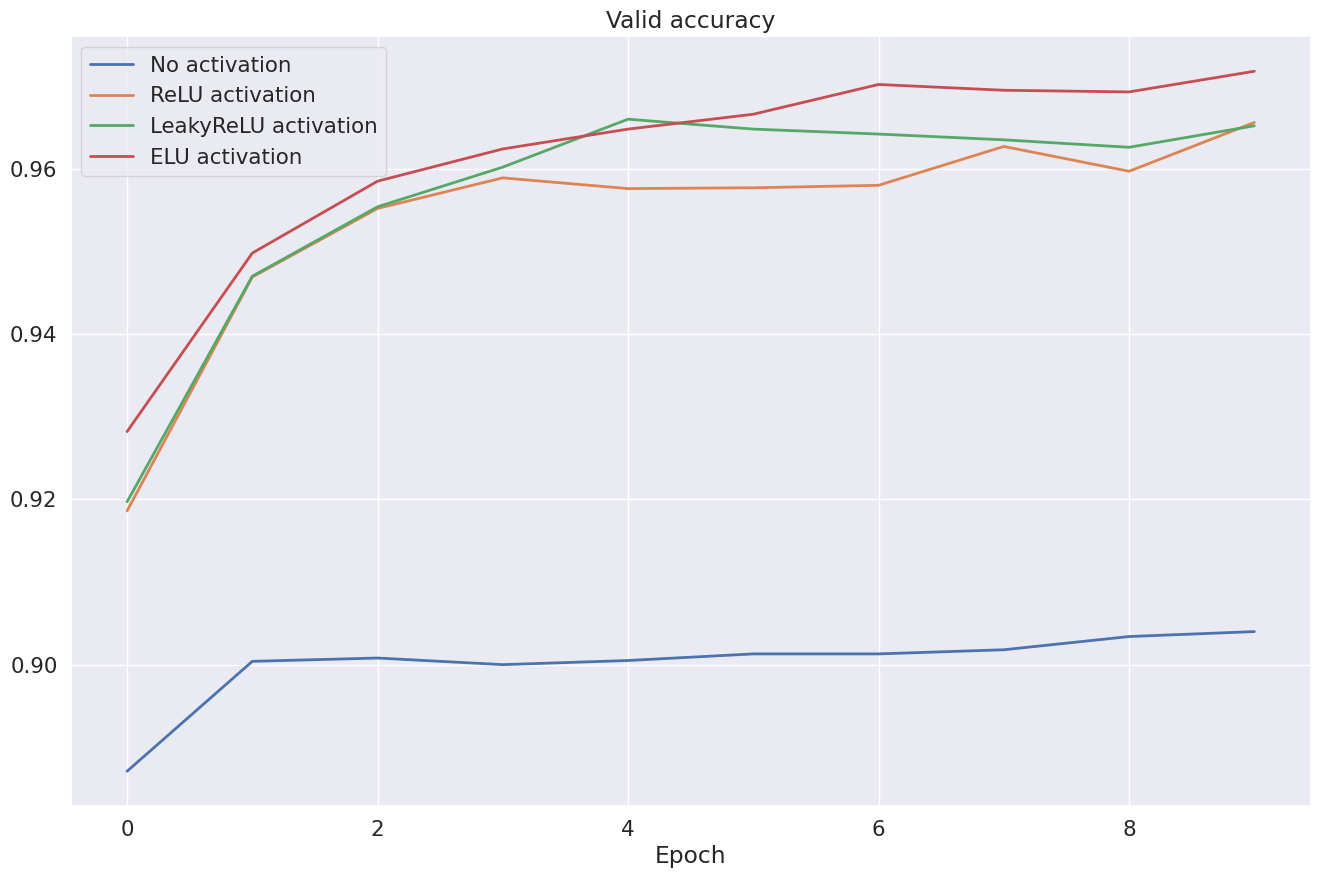

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

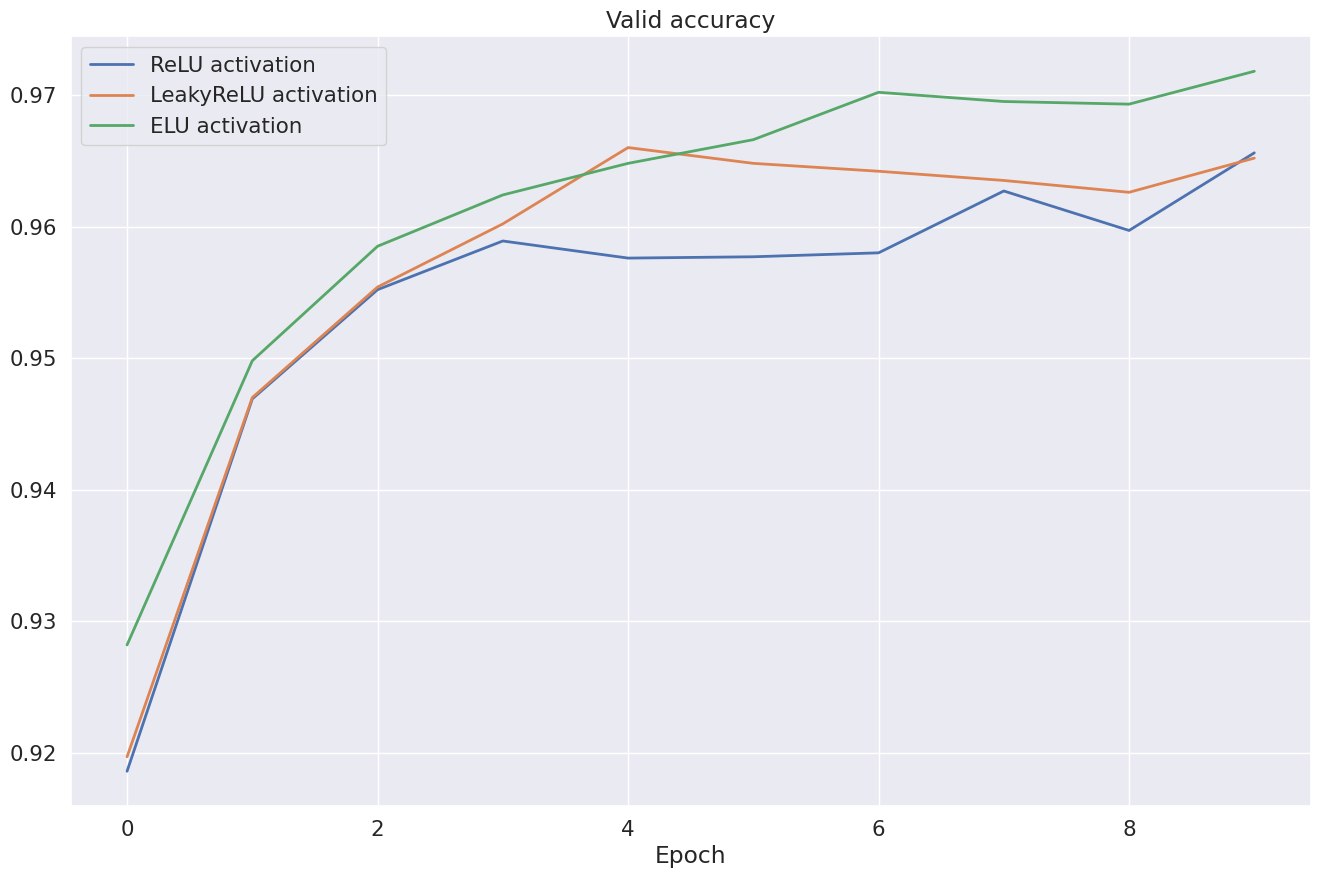

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-05 12:04:17--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   233KB/s    in 0.2s    

2023-11-05 12:04:18 (233 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



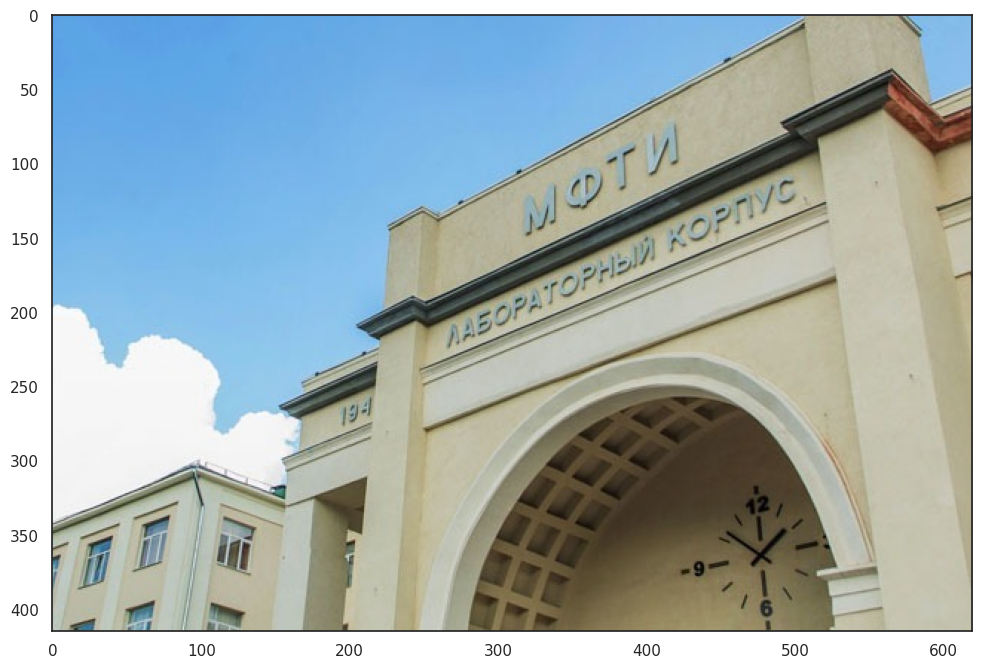

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

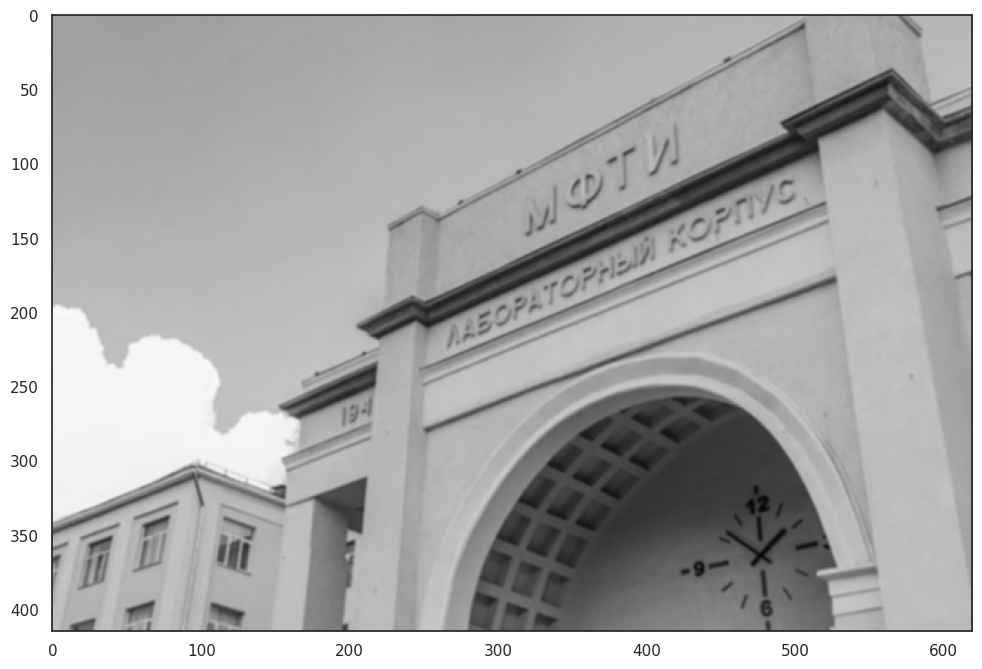

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1) Е;

2) Д;

3) А;

4) В;

5) Б;

6) Г.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        # YOUR CODE GOES HERE
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)    # img size = 5 x 5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # YOUR CODE GOES HERE
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)
from torchinfo import summary
summary(model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 26, 26]          60
├─ReLU: 1-2                              [128, 6, 26, 26]          --
├─MaxPool2d: 1-3                         [128, 6, 13, 13]          --
├─Conv2d: 1-4                            [128, 16, 11, 11]         880
├─ReLU: 1-5                              [128, 16, 11, 11]         --
├─MaxPool2d: 1-6                         [128, 16, 5, 5]           --
├─Flatten: 1-7                           [128, 400]                --
├─Linear: 1-8                            [128, 120]                48,120
├─ReLU: 1-9                              [128, 120]                --
├─Linear: 1-10                           [128, 84]                 10,164
├─ReLU: 1-11                             [128, 84]                 --
├─Linear: 1-12                           [128, 10]                 850
Total

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
# YOUR CODE GOES HERE
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        utils.set_global_seed(42 + epoch)
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 outp = model(x_batch.to(device))
                 optimizer.zero_grad()
                 loss = criterion(outp, y_batch.to(device))
                 loss.backward()
                 optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8900333333333333
Loader: valid. Accuracy: 0.9643
Epoch: 2
Loader: train. Accuracy: 0.9723166666666667
Loader: valid. Accuracy: 0.9789
Epoch: 3
Loader: train. Accuracy: 0.9810333333333333
Loader: valid. Accuracy: 0.9844
Epoch: 4
Loader: train. Accuracy: 0.9848833333333333
Loader: valid. Accuracy: 0.9856
Epoch: 5
Loader: train. Accuracy: 0.98775
Loader: valid. Accuracy: 0.9857
Epoch: 6
Loader: train. Accuracy: 0.9893833333333333
Loader: valid. Accuracy: 0.9851
Epoch: 7
Loader: train. Accuracy: 0.9908833333333333
Loader: valid. Accuracy: 0.9856
Epoch: 8
Loader: train. Accuracy: 0.99205
Loader: valid. Accuracy: 0.9853
Epoch: 9
Loader: train. Accuracy: 0.99345
Loader: valid. Accuracy: 0.9867
Epoch: 10
Loader: train. Accuracy: 0.9944166666666666
Loader: valid. Accuracy: 0.9862


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

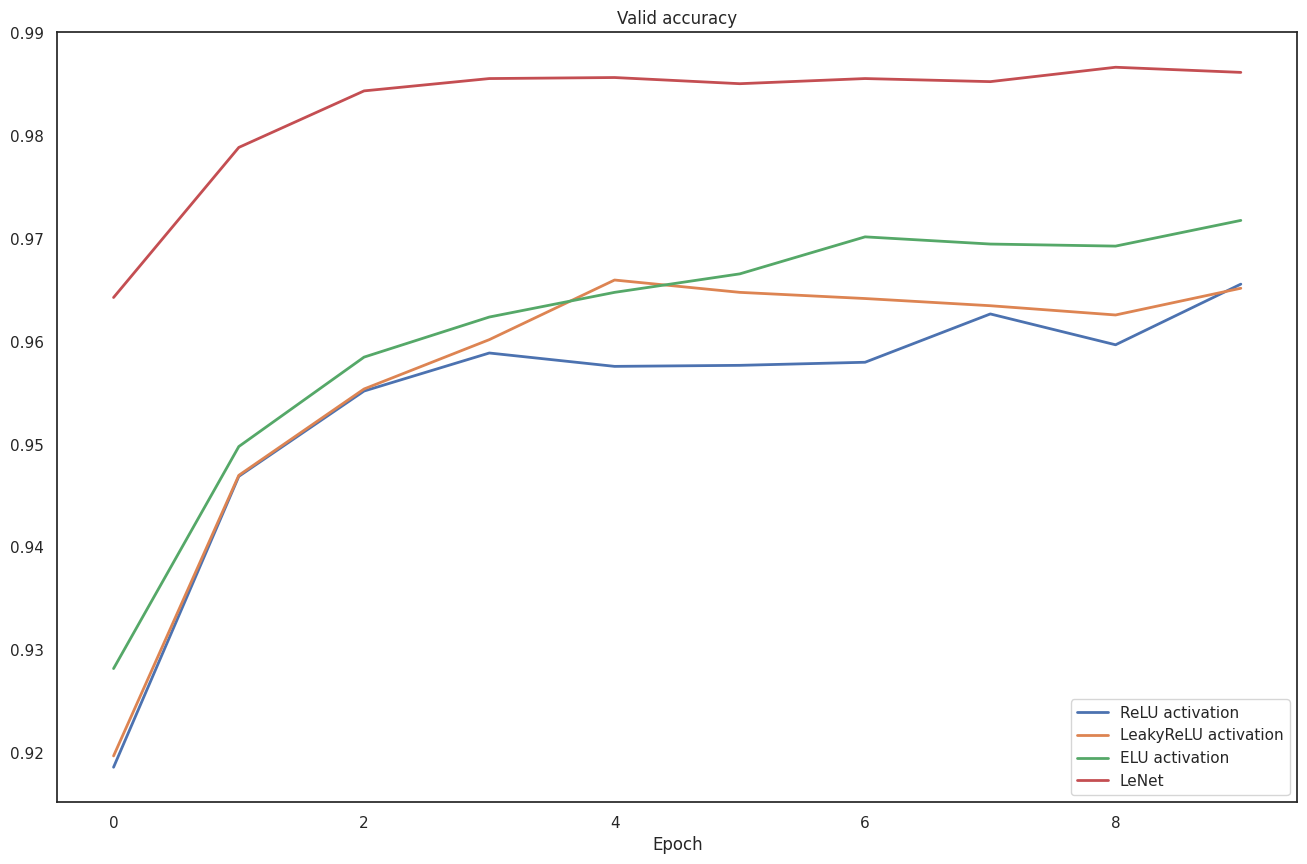

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
# YOUR CODE GOES HERE
round(lenet_accuracy[-1], 2)

0.99

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99